# Gesture Recognition Project

# Overview - Business Understanding

Imagine you are working as a data scientist at a home electronics company which manufactures state of the art smart televisions. You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote.

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:

- Thumbs up:  Increase the volume
- Thumbs down: Decrease the volume
- Left swipe: 'Jump' backwards 10 seconds
- Right swipe: 'Jump' forward 10 seconds  
- Stop: Pause the movie
 

Each video is a sequence of 30 frames (or images).

##  Business Objectives

You want to develop a cool feature in the smart-TV that can recognise five different gestures performed by the user which will help users control the TV without using a remote using a custom convolutional neural network in TensorFlow.

Approch will be
- Generator: The generator should be able to take a batch of videos as input without any error. Steps like cropping, resizing and normalization should be performed successfully.

- Model: Develop a model that is able to train without any errors which will be judged on the total number of parameters (as the inference(prediction) time should be less) and the accuracy achieved. As suggested by Snehansu, start training on a small amount of data and then proceed further.

- Write up: This should contain the detailed procedure followed in choosing the final model. The write up should start with the reason for choosing the base model, then highlight the reasons and metrics taken into consideration to modify and experiment to arrive at the final model.

# IMPORT LIBRARIES AND DATASETS

In [3]:
!pip install opencv-Python

In [39]:
# Importing the necessary libraries

import numpy as np
import os

import datetime
import os
import warnings
warnings.filterwarnings("ignore")
import abc
from sys import getsizeof

np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

tf.random.set_seed(30)

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# importing some other libraries which will be needed for model building.

from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import optimizers
from keras.layers import Dropout

We set the random seed so that the results don't vary drastically.

# Data Loading and Description

The training data consists of a few hundred videos categorised into one of the five classes. Each video (typically 2-3 seconds long) is divided into a sequence of 30 frames(images). These videos have been recorded by various people performing one of the five gestures in front of a webcam - similar to what the smart TV will use. 

The data is in a zip file. The zip file contains a 'train' and a 'val' folder with two CSV files for the two folders. These folders are in turn divided into subfolders where each subfolder represents a video of a particular gesture. Each subfolder, i.e. a video, contains 30 frames (or images). Note that all images in a particular video subfolder have the same dimensions but different videos may have different dimensions. Specifically, videos have two types of dimensions - either 360x360 or 120x160 (depending on the webcam used to record the videos). Hence, you will need to do some pre-processing to standardise the videos. 

 

Each row of the CSV file represents one video and contains three main pieces of information - the name of the subfolder containing the 30 images of the video, the name of the gesture and the numeric label (between 0-4) of the video.

In [ ]:
#mount google drive
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
projectPath = '/content/dgdriverive/My Drive/ML_AI/Workspace/GestureRecognition/'
%cd /content/gdrive/My Drive/ML_AI/Workspace/GestureRecognition//

In [ ]:
# #unzip the dataset
!unzip "/content/gdrive/My Drive/ML_AI/Workspace/GestureRecognition/Project_data.zip" > /dev/null

In [40]:
# Defining the path for train and test images
# Please Update the paths of the train and test dataset to run code
# project_folder='/content/gdrive/My Drive/ML_AI/Workspace/GestureRecognition/Project_data/'

# if running onn local machine 
project_folder='Project_data/'

##  Visualize the Model History Result 
##### Utils function to visualize Model History Result the training/validation accuracies/losses.

In [7]:
# function to visualize Model History Result the training/validation accuracies/losses.

def visualizeModelHistoryResult(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history['loss'])   
    axes[0].plot(history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history['categorical_accuracy'])   
    axes[1].plot(history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

# Generator - Define Base Class to create Model with generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [41]:
class ModelBuilder(metaclass= abc.ABCMeta):
    # initialisng the path where project data resides
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
    # initialising the image properties    
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
    # initialising the batch size, frames to sample and the no. of epochs
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
    # MOST IMPORTANT PART HERE - The generator function        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx):
                #performing image reading and resizing
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_UNCHANGED).astype(np.float32)
                image_resized=cv2.resize(image,(self.image_height,self.image_width))
                
#                 print("Size of original image: {}".format(image.shape))
#                 print("Size of new resized image: {}".format(image_resized.shape))
                
                #normalizing the images
                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    # cropping the images to have the targeted gestures and remove the noise from the images.
                    cropped=shifted[x0:x1,y0:y1,:]

                    # resize image
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (image_resized[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        
        earlystop = EarlyStopping( monitor="val_loss", min_delta=0,patience=10,verbose=1)
        callbacks_list = [checkpoint, LR, earlystop]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass

# Model Building & training
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Define Model for 3D Convulsion

In [42]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self):

        model = Sequential()
        model.add(Conv3D(16, (3, 3, 3), padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, (2, 2, 2), padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(128,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(64,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.25))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        #optimiser = 'sgd'
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [69]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=10,num_epochs=1)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_36 (Conv3D)           (None, 30, 160, 160, 16)  1312      
_________________________________________________________________
activation_36 (Activation)   (None, 30, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 30, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_36 (MaxPooling (None, 15, 80, 80, 16)    0         
_________________________________________________________________
conv3d_37 (Conv3D)           (None, 15, 80, 80, 32)    4128      
_________________________________________________________________
activation_37 (Activation)   (None, 15, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 15, 80, 80, 32)   

##### Sample Cropping

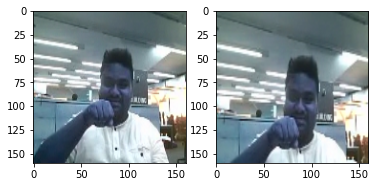

In [70]:
test_generator=ModelConv3D1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,15,:,:,:])   
axes[1].imshow(batch_data[3,15,:,:,:])   

## Experimenting with Image resolution, number of frames to use and batch_size

In [ ]:
#conv_3d1.train_model(conv_3d1_model)

### We had hit the limit on memory resources with image resolution of 160x160 with 30 frames and batch_size of 40...we get the below error

ResourceExhaustedError: OOM when allocating tensor with shape[40,16,30,160,160] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc

In [71]:
print("Memory util is {} Gigs". format(getsizeof(np.zeros((40,16,30,160,160)))/(1024*1024*1024)))

Memory util is 3.662109524011612 Gigs


##### So lets trade-off between these parameters

##### Below are the experiments to see how training time is affected by image resolution, number of images in sequence and batch size

## Experiment Number 1 : Conv3D

In [72]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=100,image_width=100)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=20,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 687813
Epoch 1/2
34/34 [==============================] - 598s 18s/step - loss: 1.8705 - categorical_accuracy: 0.3584 - val_loss: 3.3447 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 3.34472, saving model to model_init_2023-02-1323_57_16.749250/model-00001-1.64296-0.39668-3.34472-0.16000.h5
Epoch 2/2
34/34 [==============================] - 591s 17s/step - loss: 1.1519 - categorical_accuracy: 0.5309 - val_loss: 5.2336 - val_categorical_accuracy: 0.1700

Epoch 00002: val_loss did not improve from 3.34472


## Experiment Number 2 : Conv3D

In [74]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=30,batch_size=30,num_epochs=2)
conv_3d1_model=conv_3d1.define_model()
print("Total Params:", conv_3d1_model.count_params())
conv_3d1.train_model(conv_3d1_model)

Total Params: 1736389
Epoch 1/2
23/23 [==============================] - 1586s 68s/step - loss: 1.6527 - categorical_accuracy: 0.3669 - val_loss: 3.2045 - val_categorical_accuracy: 0.1600

Epoch 00001: val_loss improved from inf to 3.20453, saving model to model_init_2023-02-1400_17_07.710241/model-00001-1.48132-0.43741-3.20453-0.16000.h5
Epoch 2/2
23/23 [==============================] - 1543s 66s/step - loss: 0.9717 - categorical_accuracy: 0.6035 - val_loss: 6.0981 - val_categorical_accuracy: 0.1500

Epoch 00002: val_loss did not improve from 3.20453


- As we see from the above experiments **"image resolution"** and **number of frames** in sequence have more impact on training time than **batch_size**
- We can consider the Batch Size around 15-40
- We will change the resoulution (160,160), (120,120) according the model performance


## Experiment Number 3 : Conv3D

Base Model - Batch Size = 40 and No. of Epochs = 15

In [75]:
class ModelConv3D1(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))

        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [76]:
conv_3d1=ModelConv3D1()
conv_3d1.initialize_path(project_folder)
conv_3d1.initialize_image_properties(image_height=160,image_width=160)
conv_3d1.initialize_hyperparams(frames_to_sample=20,batch_size=40,num_epochs=15)
conv_3d1_model=conv_3d1.define_model()
conv_3d1_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_48 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_48 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_72 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_48 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_49 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_49 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_73 (Batc (None, 10, 80, 80, 32)  

In [77]:
print("Total Params:", conv_3d1_model.count_params())
history_model1 = conv_3d1.train_model(conv_3d1_model)

Total Params: 1117061
Epoch 1/15
17/17 [==============================] - 1081s 63s/step - loss: 1.9309 - categorical_accuracy: 0.3421 - val_loss: 1.5831 - val_categorical_accuracy: 0.2300

Epoch 00001: val_loss improved from inf to 1.58313, saving model to model_init_2023-02-1401_10_03.428233/model-00001-1.65847-0.40121-1.58313-0.23000.h5
Epoch 2/15
17/17 [==============================] - 1092s 64s/step - loss: 1.0322 - categorical_accuracy: 0.5867 - val_loss: 2.3319 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss did not improve from 1.58313
Epoch 3/15
17/17 [==============================] - 1078s 63s/step - loss: 0.7578 - categorical_accuracy: 0.7136 - val_loss: 2.7993 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss did not improve from 1.58313
Epoch 4/15
17/17 [==============================] - 1068s 62s/step - loss: 0.5448 - categorical_accuracy: 0.8046 - val_loss: 3.3265 - val_categorical_accuracy: 0.2100

Epoch 00004: val_loss did not improve from 1.58313
E

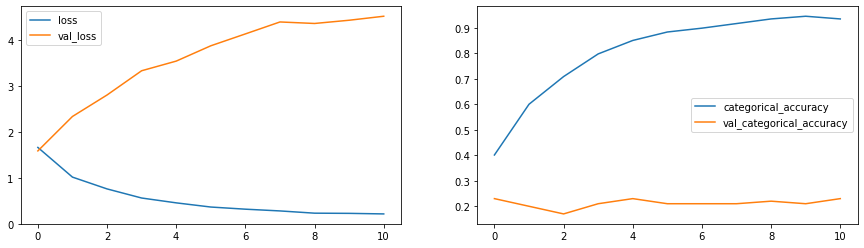

In [78]:
visualizeModelHistoryResult(history_model1)

**Model is clearly overfitting.**

## Experiment Number 4 : Conv3D

Adding dropout layers - Batch Size = 20 and No. of Epochs = 25

In [79]:
conv_3d2=ModelConv3D1()
conv_3d2.initialize_path(project_folder)
conv_3d2.initialize_image_properties(image_height=160,image_width=160)
conv_3d2.initialize_hyperparams(frames_to_sample=20,batch_size=20,num_epochs=25)
conv_3d2_model=conv_3d2.define_model(dense_neurons=256,dropout=0.5)
conv_3d2_model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_52 (Conv3D)           (None, 20, 160, 160, 16)  1312      
_________________________________________________________________
activation_52 (Activation)   (None, 20, 160, 160, 16)  0         
_________________________________________________________________
batch_normalization_78 (Batc (None, 20, 160, 160, 16)  64        
_________________________________________________________________
max_pooling3d_52 (MaxPooling (None, 10, 80, 80, 16)    0         
_________________________________________________________________
conv3d_53 (Conv3D)           (None, 10, 80, 80, 32)    13856     
_________________________________________________________________
activation_53 (Activation)   (None, 10, 80, 80, 32)    0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 10, 80, 80, 32)  

In [ ]:
print("Total Params:", conv_3d2_model.count_params())
history_model2=conv_3d2.train_model(conv_3d2_model,augment_data=True)

Total Params: 3638981
Epoch 1/25
34/34 [==============================] - 2133s 63s/step - loss: 2.1635 - categorical_accuracy: 0.3466 - val_loss: 1.7364 - val_categorical_accuracy: 0.3100

Epoch 00001: val_loss improved from inf to 1.73641, saving model to model_init_2023-02-1404_26_27.805544/model-00001-1.90351-0.40196-1.73641-0.31000.h5
Epoch 2/25
34/34 [==============================] - 2121s 62s/step - loss: 1.3300 - categorical_accuracy: 0.5226 - val_loss: 2.6817 - val_categorical_accuracy: 0.2100

Epoch 00002: val_loss did not improve from 1.73641
Epoch 3/25
34/34 [==============================] - 2114s 62s/step - loss: 1.1691 - categorical_accuracy: 0.5964 - val_loss: 3.3305 - val_categorical_accuracy: 0.2900

Epoch 00003: val_loss did not improve from 1.73641
Epoch 4/25
34/34 [==============================] - 2136s 63s/step - loss: 1.0616 - categorical_accuracy: 0.5931 - val_loss: 3.9196 - val_categorical_accuracy: 0.2200

Epoch 00004: val_loss did not improve from 1.73641
E

In [ ]:
visualizeModelHistoryResult(history_model2)

##### We can see  val_loss did not improve from 1.73641 so earlystopping stops the epoch automatically!! 
- Last Epoch stop on 11/25!! 
- Best weights save automatically. The validation accuracy of only 23% and training accuracy of 74%. 
- Next we can try to reduce the filter size and image resolution and see if get better results. Moreover since we see minor oscillations in loss.

## Experiment Number 5 : Conv3D

Adding dropout at convolution layers

In [9]:
class ModelConv3D5(ModelBuilder):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [10]:
conv_3d5=ModelConv3D5()
conv_3d5.initialize_path(project_folder)
conv_3d5.initialize_image_properties(image_height=120,image_width=120)
conv_3d5.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=15)
conv_3d5_model=conv_3d5.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d5_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 8, 60, 60, 16)     0

In [11]:
print("Total Params:", conv_3d5_model.count_params())
history_model5=conv_3d5.train_model(conv_3d5_model,augment_data=True)

Total Params: 2556533
Epoch 1/15
34/34 [==============================] - 1602s 47s/step - loss: 1.8492 - categorical_accuracy: 0.3362 - val_loss: 1.9738 - val_categorical_accuracy: 0.2100

Epoch 00001: val_loss improved from inf to 1.97384, saving model to model_init_2023-02-1413_37_39.799769/model-00001-1.65787-0.39819-1.97384-0.21000.h5
Epoch 2/15
34/34 [==============================] - 1627s 48s/step - loss: 1.3198 - categorical_accuracy: 0.4947 - val_loss: 2.7170 - val_categorical_accuracy: 0.2300

Epoch 00002: val_loss did not improve from 1.97384
Epoch 3/15
34/34 [==============================] - 1584s 47s/step - loss: 1.1012 - categorical_accuracy: 0.5948 - val_loss: 4.9851 - val_categorical_accuracy: 0.1700

Epoch 00003: val_loss did not improve from 1.97384
Epoch 4/15
34/34 [==============================] - 1566s 46s/step - loss: 1.0323 - categorical_accuracy: 0.5849 - val_loss: 5.6243 - val_categorical_accuracy: 0.2300

Epoch 00004: val_loss did not improve from 1.97384
E

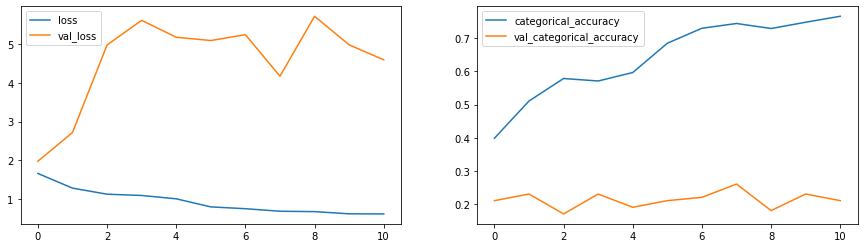

In [12]:
visualizeModelHistoryResult(history_model5)

 **Ohh! Overfitting again!!**
 
- Adding dropouts has further reduced validation accuracy as the model doesn't seem to generalise well.
- All the experimental models above have more than 1 million parameters. 
- We can try to reduce the model size to create & train low memory foot print model and see the better performance**

## Experiment Number 6 : CNN-LSTM Model

In [13]:
class RNNCNN1(ModelBuilder):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        #model.add(TimeDistributed(Conv2D(512, (2, 2) , padding='valid', activation='relu')))
       # model.add(TimeDistributed(BatchNormalization()))
       # model.add(TimeDistributed(MaxPooling2D((2, 2))))

        model.add(TimeDistributed(Flatten()))


        model.add(LSTM(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [14]:
rnn_cnn1=RNNCNN1()
rnn_cnn1.initialize_path(project_folder)
rnn_cnn1.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn1.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn1_model=rnn_cnn1.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn1_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 30, 30, 64)   

In [15]:
print("Total Params:", rnn_cnn1_model.count_params())
history_model8=rnn_cnn1.train_model(rnn_cnn1_model,augment_data=True)

Total Params: 1657445
Epoch 1/20
34/34 [==============================] - 182s 5s/step - loss: 1.5741 - categorical_accuracy: 0.2776 - val_loss: 1.7795 - val_categorical_accuracy: 0.1700

Epoch 00001: val_loss improved from inf to 1.77954, saving model to model_init_2023-02-1418_48_31.204017/model-00001-1.47005-0.34087-1.77954-0.17000.h5
Epoch 2/20
34/34 [==============================] - 176s 5s/step - loss: 1.1743 - categorical_accuracy: 0.5354 - val_loss: 1.7771 - val_categorical_accuracy: 0.2000

Epoch 00002: val_loss improved from 1.77954 to 1.77707, saving model to model_init_2023-02-1418_48_31.204017/model-00002-1.17133-0.51282-1.77707-0.20000.h5
Epoch 3/20
34/34 [==============================] - 177s 5s/step - loss: 1.0299 - categorical_accuracy: 0.5908 - val_loss: 2.0153 - val_categorical_accuracy: 0.2700

Epoch 00003: val_loss did not improve from 1.77707
Epoch 4/20
34/34 [==============================] - 180s 5s/step - loss: 0.9180 - categorical_accuracy: 0.6505 - val_loss

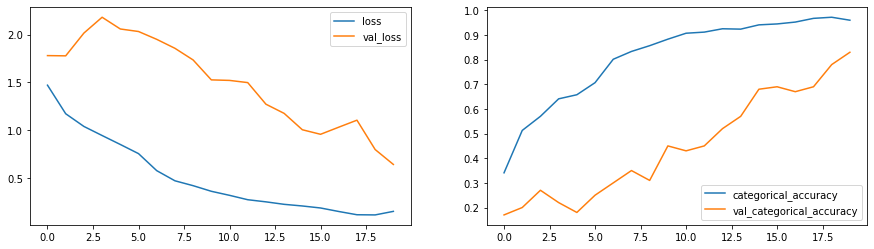

In [16]:
visualizeModelHistoryResult(history_model8)

**For CNN LSTM model we get a best validation accuracy of 83%**

As we see more cases of overfitting, lets augment the data with ***slight rotation*** as well and run the same set of models again

## Let's apply some data augmentation & check the model performance.

In [43]:
class ModelBuilderMoreAugmentation(metaclass= abc.ABCMeta):
    
    def initialize_path(self,project_folder):
        self.train_doc = np.random.permutation(open(project_folder + '/' + 'train.csv').readlines())
        self.val_doc = np.random.permutation(open(project_folder + '/' + 'val.csv').readlines())
        self.train_path = project_folder + '/' + 'train'
        self.val_path =  project_folder + '/' + 'val'
        self.num_train_sequences = len(self.train_doc)
        self.num_val_sequences = len(self.val_doc)
        
    def initialize_image_properties(self,image_height=100,image_width=100):
        self.image_height=image_height
        self.image_width=image_width
        self.channels=3
        self.num_classes=5
        self.total_frames=30
          
    def initialize_hyperparams(self,frames_to_sample=30,batch_size=20,num_epochs=20):
        self.frames_to_sample=frames_to_sample
        self.batch_size=batch_size
        self.num_epochs=num_epochs
        
        
    def generator(self,source_path, folder_list, augment=False):
        img_idx = np.round(np.linspace(0,self.total_frames-1,self.frames_to_sample)).astype(int)
        batch_size=self.batch_size
        while True:
            t = np.random.permutation(folder_list)
            num_batches = len(t)//batch_size
        
            for batch in range(num_batches): 
                batch_data, batch_labels= self.one_batch_data(source_path,t,batch,batch_size,img_idx,augment)
                yield batch_data, batch_labels 

            remaining_seq=len(t)%batch_size
        
            if (remaining_seq != 0):
                batch_data, batch_labels= self.one_batch_data(source_path,t,num_batches,batch_size,img_idx,augment,remaining_seq)
                yield batch_data, batch_labels 
    
    
    def one_batch_data(self,source_path,t,batch,batch_size,img_idx,augment,remaining_seq=0):
    
        seq_len = remaining_seq if remaining_seq else batch_size
    
        batch_data = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels)) 
        batch_labels = np.zeros((seq_len,self.num_classes)) 
    
        if (augment): batch_data_aug = np.zeros((seq_len,len(img_idx),self.image_height,self.image_width,self.channels))

        
        for folder in range(seq_len): 
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
            for idx,item in enumerate(img_idx): 
                
                image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item], cv2.IMREAD_UNCHANGED).astype(np.float32)

                
                image_resized=cv2.resize(image,(self.image_height,self.image_width))
                
#                 print("Size of original image: {}".format(image.shape))
#                 print("Size of new resized image: {}".format(image_resized.shape))
            

                batch_data[folder,idx,:,:,0] = (image_resized[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (image_resized[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (image_resized[:,:,2])/255
            
                if (augment):
                    shifted = cv2.warpAffine(image, 
                                             np.float32([[1, 0, np.random.randint(-30,30)],[0, 1, np.random.randint(-30,30)]]), 
                                            (image.shape[1], image.shape[0]))
                    
                    gray = cv2.cvtColor(shifted,cv2.COLOR_BGR2GRAY)

                    x0, y0 = np.argwhere(gray > 0).min(axis=0)
                    x1, y1 = np.argwhere(gray > 0).max(axis=0) 
                    
                    cropped=shifted[x0:x1,y0:y1,:]
                    
                    
                    image_resized=cv2.resize(cropped,(self.image_height,self.image_width))
                    
                    M = cv2.getRotationMatrix2D((self.image_width//2,self.image_height//2),
                                                np.random.randint(-10,10), 1.0)
                    rotated = cv2.warpAffine(image_resized, M, (self.image_width, self.image_height))
                    
                    #shifted = cv2.warpAffine(image_resized, 
                    #                        np.float32([[1, 0, np.random.randint(-3,3)],[0, 1, np.random.randint(-3,3)]]), 
                    #                        (image_resized.shape[1], image_resized.shape[0]))
            
                    batch_data_aug[folder,idx,:,:,0] = (rotated[:,:,0])/255
                    batch_data_aug[folder,idx,:,:,1] = (rotated[:,:,1])/255
                    batch_data_aug[folder,idx,:,:,2] = (rotated[:,:,2])/255
                
            
            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            
    
        if (augment):
            batch_data=np.concatenate([batch_data,batch_data_aug])
            batch_labels=np.concatenate([batch_labels,batch_labels])

        
        return(batch_data,batch_labels)
    
    
    def train_model(self, model, augment_data=False):
        train_generator = self.generator(self.train_path, self.train_doc,augment=augment_data)
        val_generator = self.generator(self.val_path, self.val_doc)

        model_name = 'model_init' + '_' + str(datetime.datetime.now()).replace(' ','').replace(':','_') + '/'
    
        if not os.path.exists(model_name):
            os.mkdir(model_name)
        
        filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

        checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)
        LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4)
        callbacks_list = [checkpoint, LR]

        if (self.num_train_sequences%self.batch_size) == 0:
            steps_per_epoch = int(self.num_train_sequences/self.batch_size)
        else:
            steps_per_epoch = (self.num_train_sequences//self.batch_size) + 1

        if (self.num_val_sequences%self.batch_size) == 0:
            validation_steps = int(self.num_val_sequences/self.batch_size)
        else:
            validation_steps = (self.num_val_sequences//self.batch_size) + 1
    
        history=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=self.num_epochs, verbose=1, 
                            callbacks=callbacks_list, validation_data=val_generator, 
                            validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)
        return history

        
    @abc.abstractmethod
    def define_model(self):
        pass
    
    

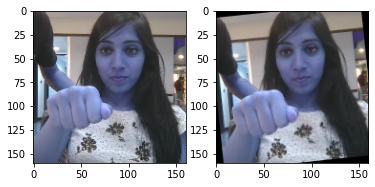

In [18]:
class Test(ModelBuilderMoreAugmentation):
    def define_model(self):
        pass

test_generator=Test()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=160,image_width=160)
test_generator.initialize_hyperparams(frames_to_sample=30,batch_size=3,num_epochs=1)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=True)
batch_data, batch_labels=next(g)
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].imshow(batch_data[0,29,:,:,:])   
axes[1].imshow(batch_data[3,29,:,:,:])   

## Experiment Number 7 : Conv3D with Data Augmentation


In [19]:
class ModelConv3D12(ModelBuilderMoreAugmentation):
    
    def define_model(self,filtersize=(3,3,3),dense_neurons=64,dropout=0.25):

        model = Sequential()
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(16, filtersize, padding='same',
                 input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(32, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(64, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))

        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(Conv3D(128, filtersize, padding='same'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        
        model.add(MaxPooling3D(pool_size=(2, 2, 2)))
        model.add(Dropout(dropout))
        
        model.add(Flatten())
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))

        model.add(Dense(dense_neurons,activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(dropout))


        model.add(Dense(self.num_classes,activation='softmax'))

        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [20]:
conv_3d12=ModelConv3D12()
conv_3d12.initialize_path(project_folder)
conv_3d12.initialize_image_properties(image_height=120,image_width=120)
conv_3d12.initialize_hyperparams(frames_to_sample=16,batch_size=20,num_epochs=25)
conv_3d12_model=conv_3d12.define_model(filtersize=(3,3,3),dense_neurons=256,dropout=0.25)
conv_3d12_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 16, 120, 120, 16)  1312      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 16, 120, 120, 16)  6928      
_________________________________________________________________
activation_9 (Activation)    (None, 16, 120, 120, 16)  0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 16, 120, 120, 16)  64        
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 8, 60, 60, 16)    

In [21]:
print("Total Params:", conv_3d12_model.count_params())
history_model12=conv_3d12.train_model(conv_3d12_model,augment_data=True)

Total Params: 2556533
Epoch 1/25
34/34 [==============================] - 1573s 46s/step - loss: 2.1446 - categorical_accuracy: 0.2544 - val_loss: 2.0694 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2023-02-1419_50_16.147096/model-00001-1.89167-0.32202-2.06939-0.16000.h5
Epoch 2/25
34/34 [==============================] - 1556s 46s/step - loss: 1.6132 - categorical_accuracy: 0.4015 - val_loss: 2.7301 - val_categorical_accuracy: 0.1700

Epoch 00002: saving model to model_init_2023-02-1419_50_16.147096/model-00002-1.54451-0.42609-2.73012-0.17000.h5
Epoch 3/25
34/34 [==============================] - 1563s 46s/step - loss: 1.4702 - categorical_accuracy: 0.4443 - val_loss: 4.1723 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2023-02-1419_50_16.147096/model-00003-1.40042-0.46908-4.17231-0.16000.h5
Epoch 4/25
34/34 [==============================] - 1563s 46s/step - loss: 1.3009 - categorical_accuracy: 0.5250 - val_loss: 4.1798 - v

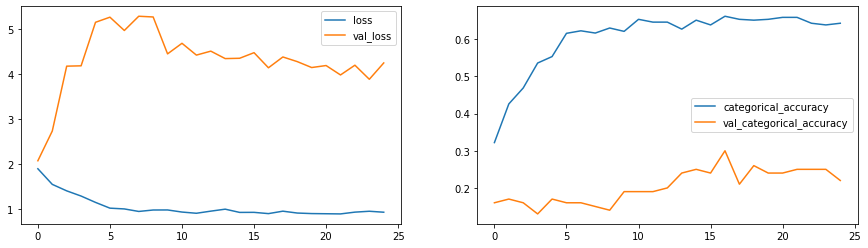

In [22]:
visualizeModelHistoryResult(history_model12)

**Model is overfitting badly !!**

## Experiment Number 8 : CNN-LSTM GRU with Data Augmentation

In [23]:
class RNNCNN2(ModelBuilderMoreAugmentation):
    
    def define_model(self,lstm_cells=64,dense_neurons=64,dropout=0.25):

        model = Sequential()

        model.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        
        model.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        

        model.add(TimeDistributed(Flatten()))


        model.add(GRU(lstm_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        optimiser = optimizers.Adam(lr=0.0002)
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

In [24]:
rnn_cnn2=RNNCNN2()
rnn_cnn2.initialize_path(project_folder)
rnn_cnn2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn2.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)
rnn_cnn2_model=rnn_cnn2.define_model(lstm_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn2_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 18, 120, 120, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 18, 120, 120, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 18, 60, 60, 16)    0         
_________________________________________________________________
time_distributed_19 (TimeDis (None, 18, 60, 60, 32)    4640      
_________________________________________________________________
time_distributed_20 (TimeDis (None, 18, 60, 60, 32)    128       
_________________________________________________________________
time_distributed_21 (TimeDis (None, 18, 30, 30, 32)    0         
_________________________________________________________________
time_distributed_22 (TimeDis (None, 18, 30, 30, 64)   

In [25]:
print("Total Params:", rnn_cnn2_model.count_params())
history_model15=rnn_cnn2.train_model(rnn_cnn2_model,augment_data=True)

Total Params: 2573925
Epoch 1/20
34/34 [==============================] - 175s 5s/step - loss: 1.7154 - categorical_accuracy: 0.2744 - val_loss: 1.6486 - val_categorical_accuracy: 0.2400

Epoch 00001: saving model to model_init_2023-02-1506_53_11.317240/model-00001-1.52673-0.35445-1.64857-0.24000.h5
Epoch 2/20
34/34 [==============================] - 172s 5s/step - loss: 1.1203 - categorical_accuracy: 0.5709 - val_loss: 1.8994 - val_categorical_accuracy: 0.1800

Epoch 00002: saving model to model_init_2023-02-1506_53_11.317240/model-00002-1.12456-0.55430-1.89936-0.18000.h5
Epoch 3/20
34/34 [==============================] - 172s 5s/step - loss: 0.9220 - categorical_accuracy: 0.6698 - val_loss: 2.1752 - val_categorical_accuracy: 0.2000

Epoch 00003: saving model to model_init_2023-02-1506_53_11.317240/model-00003-0.90105-0.66516-2.17520-0.20000.h5
Epoch 4/20
34/34 [==============================] - 172s 5s/step - loss: 0.7555 - categorical_accuracy: 0.7259 - val_loss: 2.5921 - val_categ

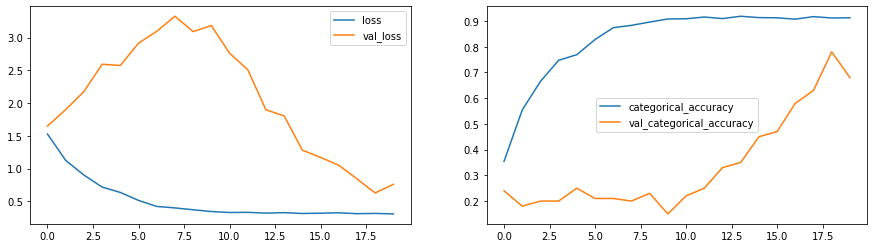

In [26]:
visualizeModelHistoryResult(history_model15)

### We see that overfitting is considerably high when we do more augmentation. However there is not much improvement on accuracy

### Let us bring in Transfer Learning !! :)

## Experiment Number 9 : Transfer Learning with GRU

In [29]:
# importing the MobileNet model due to it's lightweight architecture and high speed performance as compared 
# to other heavy-duty models like VGG16, Alexnet, InceptionV3 etc. Also, we are now also running on low disk space 
# in the nimblebox.ai platform. 

from keras.applications import mobilenet

In [31]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

class RNNCNN_TL2(ModelBuilderMoreAugmentation):
    
    def define_model(self,gru_cells=64,dense_neurons=64,dropout=0.25):
        
        model = Sequential()
        model.add(TimeDistributed(mobilenet_transfer,input_shape=(self.frames_to_sample,self.image_height,self.image_width,self.channels)))
 
        
        model.add(TimeDistributed(BatchNormalization()))
        model.add(TimeDistributed(MaxPooling2D((2, 2))))
        model.add(TimeDistributed(Flatten()))

        model.add(GRU(gru_cells))
        model.add(Dropout(dropout))
        
        model.add(Dense(dense_neurons,activation='relu'))
        model.add(Dropout(dropout))
        
        model.add(Dense(self.num_classes, activation='softmax'))
        
        
        optimiser = optimizers.Adam()
        model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
        return model

17227776/17225924 [==============================] - 9s 1us/step


In [32]:
rnn_cnn_tl2=RNNCNN_TL2()
rnn_cnn_tl2.initialize_path(project_folder)
rnn_cnn_tl2.initialize_image_properties(image_height=120,image_width=120)
rnn_cnn_tl2.initialize_hyperparams(frames_to_sample=16,batch_size=5,num_epochs=20)
rnn_cnn_tl2_model=rnn_cnn_tl2.define_model(gru_cells=128,dense_neurons=128,dropout=0.25)
rnn_cnn_tl2_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_29 (TimeDis (None, 16, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_30 (TimeDis (None, 16, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_31 (TimeDis (None, 16, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_32 (TimeDis (None, 16, 1024)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               443136    
_________________________________________________________________
dropout_16 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)              

In [33]:
print("Total Params:", rnn_cnn_tl2_model.count_params())
history_model17=rnn_cnn_tl2.train_model(rnn_cnn_tl2_model,augment_data=True)

Total Params: 3693253
Epoch 1/20
133/133 [==============================] - 565s 4s/step - loss: 1.5400 - categorical_accuracy: 0.3545 - val_loss: 0.6821 - val_categorical_accuracy: 0.7400

Epoch 00001: saving model to model_init_2023-02-1508_52_59.404268/model-00001-1.31775-0.44721-0.68208-0.74000.h5
Epoch 2/20
133/133 [==============================] - 565s 4s/step - loss: 0.8512 - categorical_accuracy: 0.6720 - val_loss: 0.5898 - val_categorical_accuracy: 0.7800

Epoch 00002: saving model to model_init_2023-02-1508_52_59.404268/model-00002-0.79674-0.70513-0.58983-0.78000.h5
Epoch 3/20
133/133 [==============================] - 545s 4s/step - loss: 0.5407 - categorical_accuracy: 0.7929 - val_loss: 0.4862 - val_categorical_accuracy: 0.7900

Epoch 00003: saving model to model_init_2023-02-1508_52_59.404268/model-00003-0.45891-0.82353-0.48623-0.79000.h5
Epoch 4/20
133/133 [==============================] - 536s 4s/step - loss: 0.3630 - categorical_accuracy: 0.8531 - val_loss: 0.5514 - v

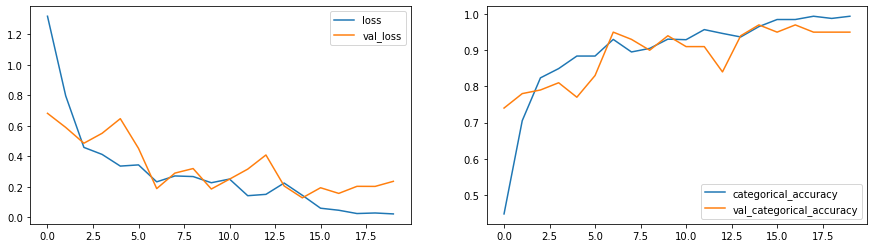

In [34]:
visualizeModelHistoryResult(history_model17)

### Awesome results! 98% Training accuracy and 93% validation accuracy :)

# Conclusion

Based on our Experiment using generator with and without augmented data and our analysis

We can see LSTM networks combat the RNN's vanishing gradients or long-term dependence issue. Gradient vanishing refers to the loss of information in a neural network as connections recur over a longer period.
In simple words, LSTM tackles gradient vanishing by ignoring useless data/information in the network.

Here is the details result of CNN-LSTM Model:
   - Training Accuracy : **93%**
   - Validation Accuracy : **83%**
   - Number of Parameters : **1,657,445** 

**Hence, we considered CNN-LSTM model is the best model, with below given weight for model testing.**

The best weights of CNN-LSTM: model-00020-0.14990-0.96003-0.64083-0.83000.h5 (20 MB). 

# Model Prediction

In [35]:
import time
from keras.models import load_model
model = load_model('model_init_2023-02-1418_48_31.204017/model-00020-0.14990-0.96003-0.64083-0.83000.h5')

In [36]:
test_generator=RNNCNN1()
test_generator.initialize_path(project_folder)
test_generator.initialize_image_properties(image_height=120,image_width=120)
test_generator.initialize_hyperparams(frames_to_sample=18,batch_size=20,num_epochs=20)

g=test_generator.generator(test_generator.val_path,test_generator.val_doc,augment=False)
batch_data, batch_labels=next(g)

In [37]:
batch_labels

array([[1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [38]:
print(np.argmax(model.predict(batch_data[:,:,:,:,:]),axis=1))

[0 2 4 1 3 1 3 3 3 0 4 4 0 4 0 2 0 0 2 2]
